<a href="https://colab.research.google.com/github/secutron/ShowTime/blob/master/dp_app0001_Lucid_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Style Transfer


![header image](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-header.jpg =512x) 

This notebook uses [**Lucid**](https://github.com/tensorflow/lucid) to perform style transfer between two images, and show how different parameterizations affect that process.

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.research.google.com/drive/1XuxLjIZj9MV-lRCpXHBhLo5A41Zs0f8E), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, Load Model

In [0]:
!pip install -q lucid>=0.2.3

In [0]:
# Imports

import numpy as np
import tensorflow as tf

from lucid.modelzoo import vision_models
from lucid.misc.io import show, load, save
from lucid.misc.tfutil import create_session

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render

We will be writing a custom objective for style transfer, so let's grab this handy decorator that allows us to take a simple function and mark it as an objective in lucid:

In [0]:
from lucid.optvis.objectives import wrap_objective

And we'll use our default vision model, GoogLeNet:

In [5]:
model = vision_models.InceptionV1()
model.load_graphdef()

You can use this to see if you're running on a machine with a correctly configured GPU:

In [6]:
tf.test.is_gpu_available()

True

## Load input images

First, let's take a look at the two images we want to transfer styles between. This code should feel familiar from the Lucid tutorial:

Later in the notebook there'll be an opportunity to upload your own images, too.

(512, 512, 3) (512, 645, 3)



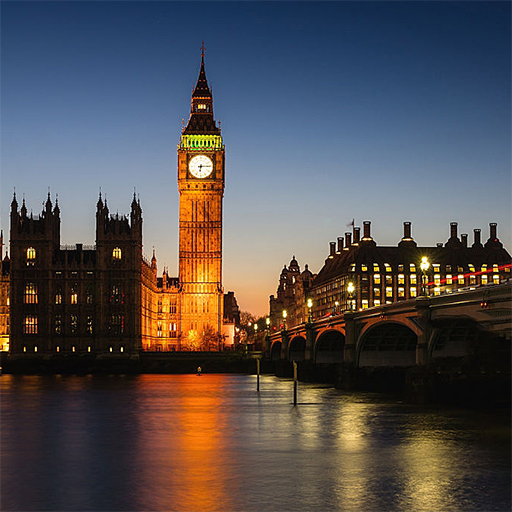


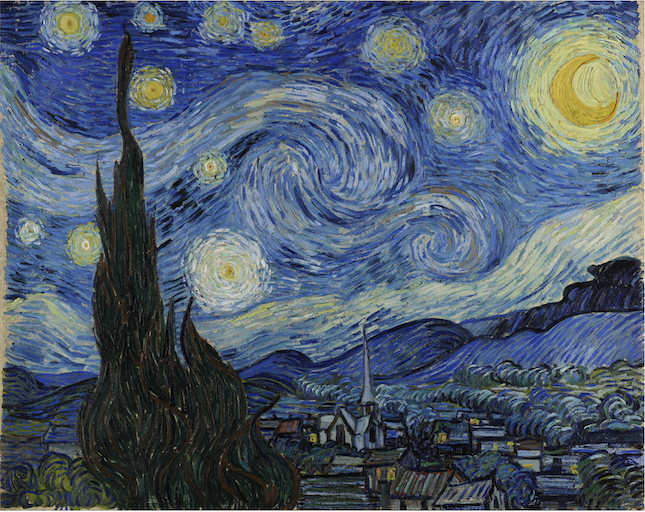

In [7]:
content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

show(content_image)
show(style_image)

## Introducing style transfer

In lucid, style transfer (rendering an image in the visual style of a different image) can be expressed compactly.

We feed two images, a **style image** and a **content image** into our model, which produces activations at all of its layers. 
From that we extract two subsets of activations, the style activations (orange) and the content activations (green), at different depths in the network. 

We then optimize an input to produce activations similar to the combined set of activations we extracted.

![styletransfer-diagram](https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-diagram.png =563x)

Which layers work best for that is an aesthetic choice. Recommended reading: [Feature Visualization](https://distill.pub/2017/feature-visualization), in which the hero graphic shows what kind of visual concepts get captured at which layers in the model we are using.

In [0]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

To feed two images + one that is being optimized into our network we will use the batch dimension of a cutsom parameterization. It consists simply of the paramaterization of the optimized image stacked with the two images.

(We also use cropping to allow style images of a larger size than content images.)

In [0]:
def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
  style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
  content_input = content_image
  style_input = tf.random_crop(style_image, content_image.shape)
  return tf.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

Let's sanity check that shapes fit and the three inputs get stacked on their batch dimension correctly:

In [10]:
style_transfer_param(content_image, style_image).shape

TensorShape([Dimension(3), Dimension(512), Dimension(512), Dimension(3)])

Here we use `@wrap_objective` to create a custom `activation_difference` objective in lucid.
It takes as arguments the layer names specifying the subset of activations, and an image.
It will extract the specified subset of activations from both the supplied image and the one we are optimizing, and compute their difference.

Optionally one can pass a loss function defining how these differences should be penalized. By default, we penalize mean L1 difference.
Also, one can pass a function transforming the subset of activations. By default, we don't transform the activations.

In [0]:
def mean_L1(a, b):
  return tf.reduce_mean(tf.abs(a-b))

In [0]:
@wrap_objective
def activation_difference(layer_names, activation_loss_f=mean_L1, transform_f=None, difference_to=CONTENT_INDEX):
  def inner(T):
    # first we collect the (constant) activations of image we're computing the difference to
    image_activations = [T(layer_name)[difference_to] for layer_name in layer_names]
    if transform_f is not None:
      image_activations = [transform_f(act) for act in image_activations]

    # we also set get the activations of the optimized image which will change during optimization
    optimization_activations = [T(layer)[TRANSFER_INDEX] for layer in layer_names]
    if transform_f is not None:
      optimization_activations = [transform_f(act) for act in optimization_activations]

    # we use the supplied loss function to compute the actual losses
    losses = [activation_loss_f(a, b) for a, b in zip(image_activations, optimization_activations)]
    return tf.add_n(losses)

  return inner

For the style loss, we do not care about the spatial information in the activations. Using a gram matrix to transform the activations before penalizing their difference works well for this:

In [0]:
def gram_matrix(array, normalize_magnitue=True):
  channels = tf.shape(array)[-1]
  array_flat = tf.reshape(array, [-1, channels])
  gram_matrix = tf.matmul(array_flat, array_flat, transpose_a=True)
  if normalize_magnitue:
    length = tf.shape(array_flat)[0]
    gram_matrix /= tf.cast(length, tf.float32)
  return gram_matrix

Now we have all the ingredients to set up an optimization in lucid: we will create two `activation_difference` objectives, a normal one for the **content loss**, and one transforming the activations using `gram_matrix` for the **style loss**.

In [14]:
param_f = lambda: style_transfer_param(content_image, style_image)

content_obj = 100 * activation_difference(content_layers, difference_to=CONTENT_INDEX)
content_obj.description = "Content Loss"

style_obj = activation_difference(style_layers, transform_f=gram_matrix, difference_to=STYLE_INDEX)
style_obj.description = "Style Loss"

objective = - content_obj - style_obj

vis = render.render_vis(model, objective, param_f=param_f, thresholds=[512], verbose=False, print_objectives=[content_obj, style_obj])[-1]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



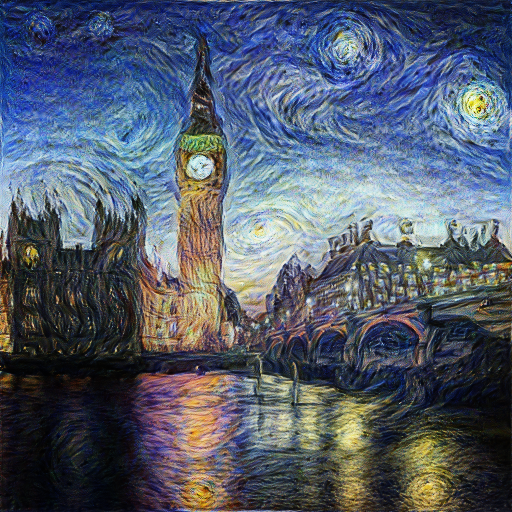
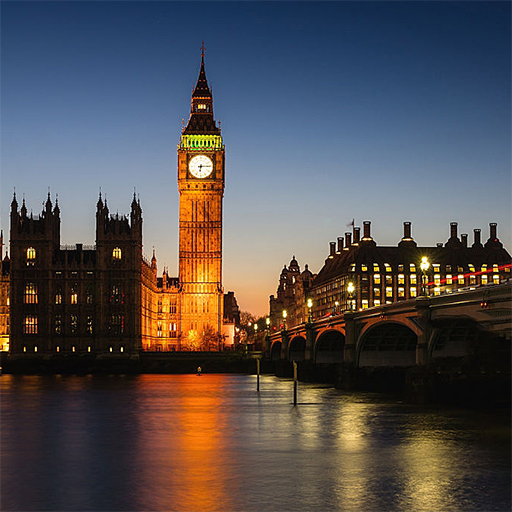
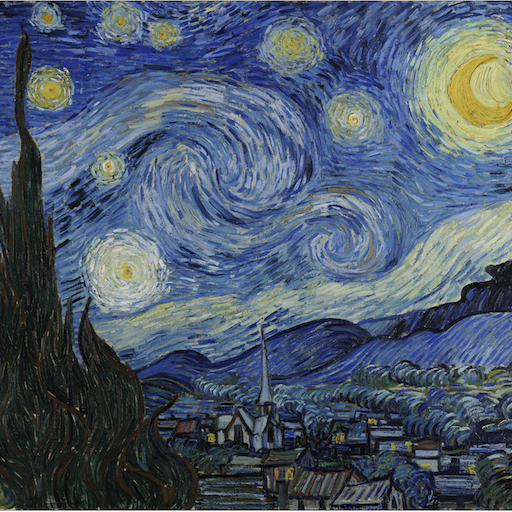

In [15]:
show(vis)